In [5]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict, Annotated

import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage


class AgentState(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list[AnyMessage], operator.add]


In [10]:
class Agent:

    def __init__(self, llm, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_ollama)
        graph.set_entry_point("llm")
        graph.add_edge("llm", END)
        self.graph = graph.compile()
        self.llm = llm
        
    def call_ollama(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.llm.invoke(messages)
        return {'messages': [message]}


In [11]:
from langchain_ollama.llms import OllamaLLM

llm = OllamaLLM(model="llama3.2:3b", base_url="http://172.16.100.97:11434")

prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""
abot = Agent(llm, system=prompt)

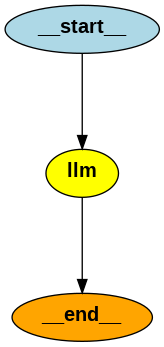

In [12]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [17]:
messages = [HumanMessage(content="Dinner ideas?")]
result = abot.graph.invoke({"messages": messages})
result["messages"][-1]

"I'd be happy to help with dinner ideas.\n\nTo get started, I'll just make a quick call to see if there's any specific cuisine or dietary preference you're interested in. Would you like dinner ideas for meat-lovers, vegetarians, seafood, or something else?\n\n(Will wait for your response before proceeding)"